## Alexnet model

In [1]:
import tensorflow as tf
import numpy as np
import random
import os
from multiprocessing import Process
import redis
import pickle
import subprocess
import keras
import time
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']=""
import keras

In [3]:
tf.test.gpu_device_name()

''

In [4]:
redis_server_path = '/data/yylaiai/redis/redis-stable/src/redis-server'

In [5]:
# open redis server on current jupyter notebook terminal
subprocess.Popen([redis_server_path])

In [6]:
model = keras.applications.MobileNetV2()
# model = keras.applications.resnet50.ResNet50()

In [7]:
# load datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_test.shape)

(10000, 32, 32, 3)


In [8]:
# expand cifar10 images from 32x32 to 224x224
x_test_224 = np.array([cv2.resize(i, (224, 224)) for i in x_test])
print(x_test_224.shape)

(10000, 224, 224, 3)


In [9]:
class GA:
    '''
    arguments e.g.:
    fit: ["inc", ["tensorflow", "theano"]]
    model: model
    dataset: x_test
    input_shape: x_test[0].shape
    init_input_mut: 0.1
    init_weight_mut: 0
    r1: 0.5
    r2: 0.1
    m: 5
    n: 1000
    db_flag: 0
    '''
    def __init__(self, fit, model, dataset, input_shape, init_input_mut, init_weight_mut, r1, r2, m, n, db_flag):
        self.fitness_func, self.phi = fit # a tuple: (fitness function, list of DL framework(s) to be used)
        self.model = model
        self.dataset = dataset
        self.input_shape = input_shape
        self.init_input_mut = init_input_mut
        self.init_weight_mut = init_weight_mut
        self.r1 = r1
        self.r2 = r2
        self.m = m
        self.n = n
        self.db_flag = db_flag
        self.redis = redis.Redis(db=db_flag)
        if not self.redis.ping():
            raise Exception("Redis server not set up")
        
    def initPopulation(self):
        # randomly choose n inputs from the dataset if n < len(dataset)
        if len(self.dataset) > self.n:
            selected_x = self.dataset[np.random.choice(len(self.dataset), size=self.n, replace=False)]
        else:
            selected_x = self.dataset
            
        # get model weights
        original_weights = np.array(self.model.get_weights(), dtype=object)
            
        self.mutated_inputs = selected_x
        self.mutated_weights = original_weights

        # input level
        if self.init_input_mut != 0 and self.init_input_mut != None:
            self.mutated_inputs = (np.clip((selected_x/255 + np.random.standard_cauchy(selected_x.shape) * self.init_input_mut),0,1) * 255).astype(int)
            
        # weight level
        # set the model weights of the GA object to the mutated weights
        if self.init_weight_mut != 0 and self.init_weight_mut != None:
            self.mutated_weights = []
            for layer_weight in original_weights:
                self.mutated_weights.append(layer_weight + np.random.standard_cauchy(layer_weight.shape) * self.init_weight_mut)
            self.model.set_weights(self.mutated_weights)
                
        return [self.mutated_inputs, self.mutated_weights]


    def computeFitness(self):
        if self.fitness_func == "inc":
            FFunc = InconsistencyFunc("get_predicts.py", 0, self.redis, self.phi, self.model, self.mutated_inputs, -1)
            self.fitness_values = FFunc.compute()
            return self.fitness_values
        elif self.fitness_func == "nan":
            FFunc = NanFunc("get_predicts.py", 0, self.redis, self.phi, self.model, self.mutated_inputs, -1)
            self.fitness_values = FFunc.compute()
            return self.fitness_values
        
    def getTopK_Fit(self, k):
        topK_idx = np.argpartition(self.fitness_values, -k)[-k:]
        return [self.mutated_inputs[topK_idx], self.fitness_values[topK_idx]]
        
        
    # select m candidates for parents of next-generation inputs
    def select(self):
        selected_index = np.argpartition(self.fitness_values, -self.m)[-self.m:]
        self.selected_x = self.mutated_inputs[selected_index]
        return self.selected_x
    
    # select 2 parents from the candidates
    def selectParents(self):
        self.x1, self.x2 = random.sample(list(self.selected_x), 2)
        return self.x1, self.x2
    
    # return a flatten list of a crossover product of the selected parents
    def crossover(self):
        x1_flatten = self.x1.flatten()
        x2_flatten = self.x2.flatten()

        x1_factor = np.random.choice(2, size=x1_flatten.shape, p=[1-self.r1, self.r1])
        x2_factor = 1 - x1_factor
        
        self.x_prime = x1_flatten * x1_factor + x2_flatten * x2_factor

        return self.x_prime
    
    # mutate the crossover product and reshape it as the shape of the input instance
    def mutate(self):
        self.x_2prime=(np.clip((self.x_prime/255 + np.random.standard_cauchy(self.x_prime.shape) * self.r2),0,1) * 255).astype(int)
        self.x_2prime = self.x_2prime.reshape(self.input_shape)
        return self.x_2prime
    
    # check if the new DNN model can predict the mutated inputs without triggering error
    def checkFailed(self):
        try:
            if self.fitness_func == "inc":
                return []

            elif self.fitness_func == "nan":
                predictions = self.model.predict(self.mutated_inputs)
                if np.isnan(predictions).any(): # if there is any nan in the predictions
                    return self.mutated_inputs
        except Exception as e:
            return [e]
            

In [10]:
class InconsistencyFunc:
    def __init__(self, py_script, db_flag, redis_server, backends, model, inputs, layer_idx):
        self.redis_server = redis_server
        self.db_flag = db_flag
        
        self.backend_1, self.backend_2 = backends
        self.model = model
        self.inputs = inputs
        self.cmd_1 = f'python {py_script} {self.backend_1} {db_flag} {layer_idx}'
        self.cmd_2 = f'python {py_script} {self.backend_2} {db_flag} {layer_idx}'
    
    def compute(self):
        # store model and inputs
        with self.redis_server.pipeline() as pipe:
            pipe.mset({"model": pickle.dumps(self.model)})
            pipe.mset({"inputs": pickle.dumps(self.inputs)})
            pipe.execute()
        
        # run subprocess to get predictions
        p1 = Process(target=lambda: os.system(self.cmd_1))
        p2 = Process(target=lambda: os.system(self.cmd_2))
        p1.start()
        p2.start()
        p1.join()
        p2.join()
        
        # load predictions
        with self.redis_server.pipeline() as pipe:
            pipe.hget(f"{self.backend_1}", "predictions")
            pipe.hget(f"{self.backend_2}", "predictions")
            predictions = pipe.execute()
        
        self.predictions_1 = pickle.loads(predictions[0])
        self.predictions_2 = pickle.loads(predictions[1])
        
        # compute fitness
        predictions_diff = np.abs(self.predictions_2 - self.predictions_1)
        
        self.fitness_values = np.sum(predictions_diff**2, axis=1) / len(self.predictions_1)
        
        return self.fitness_values


In [11]:
class NanFunc:
    def __init__(self, py_script, db_flag, redis_server, backend, model, inputs, layer_idx):
        self.redis_server = redis_server
        self.db_flag = db_flag
        
        self.model = model
        self.inputs = inputs
        self.backend = backend[0]
        self.cmd = f'python {py_script} {self.backend} {db_flag} {layer_idx}'
        
    def compute(self):
        # store model and inputs
#         with self.redis_server.pipeline() as pipe:
#             pipe.mset({"model": pickle.dumps(self.model)})
#             pipe.mset({"inputs": pickle.dumps(self.inputs)})
#             pipe.execute()

        self.redis_server.mset({"inputs": pickle.dumps(self.inputs)})
        self.redis_server.mset({"model": pickle.dumps(self.model)})



        # run subprocess to get predictions
        os.system(self.cmd)
        
        # load predictions
        self.predictions = pickle.loads(self.redis_server.hget(f"{self.backend}", "predictions"))
        
        # normalize neurons
        normalized_outputs = self.predictions/(np.amax(self.predictions) - np.amin(self.predictions))
        
        # compute fitness
        self.fitness_values = np.amax(normalized_outputs, axis=1) - np.amin(normalized_outputs, axis=1)
        
        return self.fitness_values


In [12]:
# parameters
fit = ["nan", ["tensorflow"]]
model = model
dataset = x_test[:50]
input_shape = x_test[0].shape
init_input_mut = 0.1
init_weight_mut = 0
r1 = 0.5
r2 = 0.1
m = 5
n = 50
maxIter = 10
db_flag = 0

In [13]:
def ga_main(fit, model, dataset, input_shape, init_input_mut, init_weight_mut, r1, r2, m, n, db_flag, maxIter):
    F = []
    fits = []
    ga = GA(fit, model, dataset, input_shape, init_input_mut, init_weight_mut, r1, r2, m, n, db_flag)
    x, theta = ga.initPopulation()
    start_time = time.time()
    for i in range(maxIter):
        print("Running at iteration {}:".format(i+1))
        iter_start_time = time.time()
        Fit = ga.computeFitness()
        top_k_fitness = ga.getTopK_Fit(m)
        fits.append(top_k_fitness)
        P_prime = ga.select()
        test_cases = []
        test_cases.extend(P_prime)
        while len(test_cases) < ga.n:
            x1, x2 = ga.selectParents()
            x_prime = ga.crossover()
            r = random.uniform(0,1)
            if r < ga.r2:
                x_2prime = ga.mutate()
                test_cases.append(x_2prime)

        ga.mutated_inputs = np.array(test_cases)
        X = ga.checkFailed()
        if X != None:
            F.extend(X)
        iter_end_time = time.time()
        
        print("top {} fitness scores: ".format(m), top_k_fitness[1])
        print("Taken time: {}".format(iter_end_time-iter_start_time))
        print()
    
    end_time = time.time()
    print("Total taken time: {}".format(end_time-start_time))
    
    if (i+10)%10 == 0:
        plt.plot((lambda L: [np.mean(i[1]) for i in L])(fits))

    return F, fits

In [14]:
fit_grad = lambda L: [np.mean(i[1]) for i in L]

## NaN Fitness Function for tensorflow

Running at iteration 1:
top 5 fitness scores:  [0.44926015 0.68246764 0.7459291  1.         0.83799964]
Taken time: 4.77100133895874

Running at iteration 2:
top 5 fitness scores:  [0.44926015 0.68246764 0.7459291  1.         0.83799964]
Taken time: 3.38759446144104

Running at iteration 3:
top 5 fitness scores:  [0.44926015 0.68246764 0.7459291  1.         0.83799964]
Taken time: 3.174670457839966

Running at iteration 4:
top 5 fitness scores:  [0.44926015 0.68246764 0.7459291  1.         0.83799964]
Taken time: 3.339367151260376

Running at iteration 5:
top 5 fitness scores:  [0.44926015 0.68246764 0.7459291  1.         0.83799964]
Taken time: 3.1741321086883545

Running at iteration 6:
top 5 fitness scores:  [0.44926015 0.68246764 0.7459291  1.         0.83799964]
Taken time: 3.28613018989563

Running at iteration 7:
top 5 fitness scores:  [0.44926015 0.68246764 0.7459291  1.         0.83799964]
Taken time: 3.6854705810546875

Running at iteration 8:
top 5 fitness scores:  [0.449260

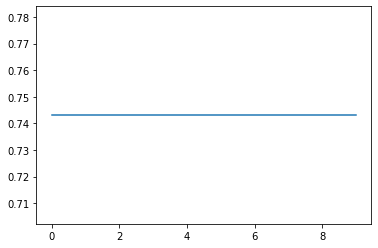

In [15]:
F, fits = ga_main(["nan", ["tensorflow"]], model, dataset, input_shape, init_input_mut, init_weight_mut, r1, r2, m, 10, db_flag, maxIter)
plt.plot(fit_grad(fits))

## NaN Fitness Function for theano

Running at iteration 1:
top 5 fitness scores:  [0.4492614  0.68246555 0.7459298  1.         0.8380022 ]
Taken time: 4.770803451538086

Running at iteration 2:
top 5 fitness scores:  [0.4492614  0.68246555 0.7459298  1.         0.8380022 ]
Taken time: 3.6343796253204346

Running at iteration 3:
top 5 fitness scores:  [0.4492614  0.68246555 0.7459298  1.         0.8380022 ]
Taken time: 3.3703384399414062

Running at iteration 4:
top 5 fitness scores:  [0.4492614  0.68246555 0.7459298  1.         0.8380022 ]
Taken time: 3.117377281188965

Running at iteration 5:
top 5 fitness scores:  [0.4492614  0.68246555 0.7459298  1.         0.8380022 ]
Taken time: 3.488297939300537

Running at iteration 6:
top 5 fitness scores:  [0.4492614  0.68246555 0.7459298  1.         0.8380022 ]
Taken time: 3.1036744117736816

Running at iteration 7:
top 5 fitness scores:  [0.4492614  0.68246555 0.7459298  1.         0.8380022 ]
Taken time: 3.2814626693725586

Running at iteration 8:
top 5 fitness scores:  [0.4

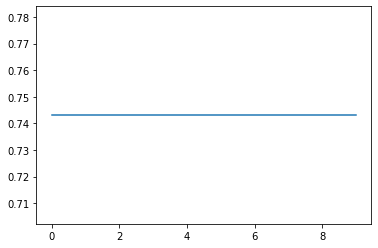

In [17]:
F, fits = ga_main(["nan", ["theano"]], model, dataset, input_shape, init_input_mut, init_weight_mut, r1, r2, m, 10, db_flag, maxIter)
plt.plot(fit_grad(fits))

## Inconsistency Fitness Function for tensorflow and theano

### Generate 10 crossover/mutated inputs in each iteration

Running at iteration 1:
top 5 fitness scores:  [1.1898959e-13 3.0812326e-13 4.1744443e-13 4.9148565e-13 6.5926561e-13]
Taken time: 4.772511005401611

Running at iteration 2:
top 5 fitness scores:  [1.1898959e-13 3.0812326e-13 4.1744443e-13 4.9148565e-13 6.5926561e-13]
Taken time: 3.498953342437744

Running at iteration 3:
top 5 fitness scores:  [1.1898959e-13 3.0812326e-13 4.1744443e-13 4.9148565e-13 6.5926561e-13]
Taken time: 3.5819592475891113

Running at iteration 4:
top 5 fitness scores:  [1.1898959e-13 3.0812326e-13 4.1744443e-13 4.9148565e-13 6.5926561e-13]
Taken time: 3.5057461261749268

Running at iteration 5:
top 5 fitness scores:  [1.1898959e-13 3.0812326e-13 4.1744443e-13 4.9148565e-13 6.5926561e-13]
Taken time: 3.775367021560669

Running at iteration 6:
top 5 fitness scores:  [1.1898959e-13 3.0812326e-13 4.1744443e-13 4.9148565e-13 6.5926561e-13]
Taken time: 4.258542537689209

Running at iteration 7:
top 5 fitness scores:  [1.1898959e-13 3.0812326e-13 4.1744443e-13 4.914856

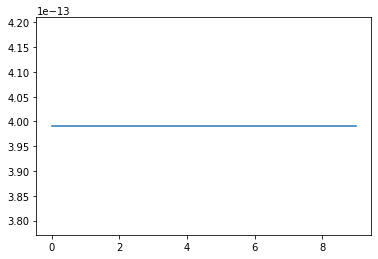

In [16]:
F, fits = ga_main(["inc", ["tensorflow", "theano"]], model, dataset, input_shape, init_input_mut, init_weight_mut, r1, r2, m, 10, db_flag, maxIter)
plt.plot(fit_grad(fits))

Running at iteration 1:
top 5 fitness scores:  [0.04 0.04 0.04 0.04 0.04]
Taken time: 16.34067726135254

Running at iteration 2:
top 5 fitness scores:  [0.04 0.04 0.04 0.04 0.04]
Taken time: 16.088501453399658

Running at iteration 3:
top 5 fitness scores:  [0.04 0.04 0.04 0.04 0.04]
Taken time: 16.400437116622925

Running at iteration 4:
top 5 fitness scores:  [0.04 0.04 0.04 0.04 0.04]
Taken time: 16.499932527542114

Running at iteration 5:
top 5 fitness scores:  [0.04 0.04 0.04 0.04 0.04]
Taken time: 16.706597328186035

Running at iteration 6:
top 5 fitness scores:  [0.04 0.04 0.04 0.04 0.04]
Taken time: 15.095474243164062

Running at iteration 7:
top 5 fitness scores:  [0.04 0.04 0.04 0.04 0.04]
Taken time: 16.38049840927124

Running at iteration 8:
top 5 fitness scores:  [0.04 0.04 0.04 0.04 0.04]
Taken time: 16.49544095993042

Running at iteration 9:
top 5 fitness scores:  [0.04 0.04 0.04 0.04 0.04]
Taken time: 15.875294923782349

Running at iteration 10:
top 5 fitness scores:  [

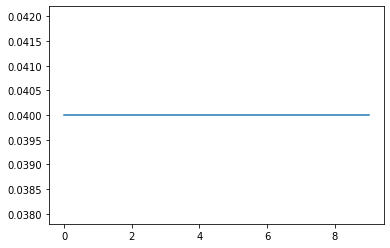

In [19]:
F, fits = ga_main(["inc", ["tensorflow", "theano"]], model, dataset, input_shape, init_input_mut, init_weight_mut, r1, r2, m, 50, db_flag, maxIter)
plt.plot(fit_grad(fits))

Running at iteration 1:
top 5 fitness scores:  [1.6200686e-14 3.9657835e-14 2.6196527e-14 5.8618685e-14 8.1470739e-14]
Taken time: 71.98358821868896

Running at iteration 2:
top 5 fitness scores:  [2.9309342e-14 4.0735370e-14 4.2495175e-14 5.0441608e-14 4.8961625e-14]
Taken time: 100.78629517555237

Running at iteration 3:
top 5 fitness scores:  [4.0735370e-14 4.2495175e-14 4.8961625e-14 5.0441608e-14 6.4379146e-14]
Taken time: 99.76256775856018

Running at iteration 4:
top 5 fitness scores:  [4.0735370e-14 4.2495175e-14 5.0441608e-14 4.8961625e-14 6.4379146e-14]
Taken time: 98.85493493080139

Running at iteration 5:
top 5 fitness scores:  [4.0735370e-14 4.2495175e-14 4.8961625e-14 5.0441608e-14 6.4379146e-14]
Taken time: 94.83056020736694

Running at iteration 6:
top 5 fitness scores:  [4.2495175e-14 4.8961625e-14 5.0441608e-14 5.7824520e-14 6.4379146e-14]
Taken time: 101.57380533218384

Running at iteration 7:
top 5 fitness scores:  [4.3925523e-14 4.8961625e-14 6.4379146e-14 5.044160

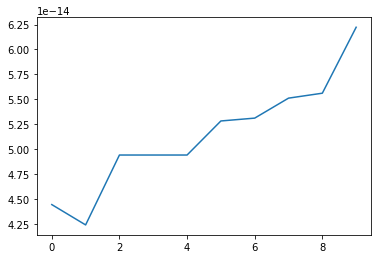

In [129]:
F, fits = ga_main(["inc", ["tensorflow", "theano"]], model, dataset, input_shape, init_input_mut, init_weight_mut, r1, r2, m, 100, db_flag, maxIter)
plt.plot(fit_grad(fits))

Running at iteration 1:
top 5 fitness scores:  [2.5402369e-14 3.1524649e-14 3.5576868e-14 4.7763053e-14 6.8324865e-13]
Taken time: 46.45337152481079

Running at iteration 2:
top 5 fitness scores:  [4.2862581e-14 4.7763053e-14 5.2967376e-14 5.8846611e-14 6.8324865e-13]
Taken time: 46.070324659347534

Running at iteration 3:
top 5 fitness scores:  [4.7763053e-14 5.2967376e-14 5.8846611e-14 1.1624187e-13 6.8324865e-13]
Taken time: 46.44286847114563

Running at iteration 4:
top 5 fitness scores:  [5.2967376e-14 5.6874007e-14 5.8846611e-14 1.1624187e-13 6.8324865e-13]
Taken time: 46.232664346694946

Running at iteration 5:
top 5 fitness scores:  [5.2967376e-14 5.6874007e-14 1.1624187e-13 5.8846611e-14 6.8324865e-13]
Taken time: 49.53388714790344

Running at iteration 6:
top 5 fitness scores:  [5.6874007e-14 5.8846611e-14 6.9829078e-14 1.1624187e-13 6.8324865e-13]
Taken time: 46.7274956703186

Running at iteration 7:
top 5 fitness scores:  [6.0671425e-14 6.9829078e-14 1.1624187e-13 4.5658984

top 5 fitness scores:  [3.9300133e-13 4.0676758e-13 4.5658984e-13 4.2497966e-13 6.8324865e-13]
Taken time: 47.48494362831116

Running at iteration 57:
top 5 fitness scores:  [3.9300133e-13 4.0676758e-13 4.2497966e-13 4.5658984e-13 6.8324865e-13]
Taken time: 46.990445613861084

Running at iteration 58:
top 5 fitness scores:  [3.9300133e-13 4.0676758e-13 4.5658984e-13 4.2497966e-13 6.8324865e-13]
Taken time: 46.53729224205017

Running at iteration 59:
top 5 fitness scores:  [3.9300133e-13 4.0676758e-13 4.2497966e-13 4.5658984e-13 6.8324865e-13]
Taken time: 47.12037205696106

Running at iteration 60:
top 5 fitness scores:  [3.9300133e-13 4.0676758e-13 4.5658984e-13 4.2497966e-13 6.8324865e-13]
Taken time: 46.52315068244934

Running at iteration 61:
top 5 fitness scores:  [3.9300133e-13 4.0676758e-13 4.2497966e-13 4.5658984e-13 6.8324865e-13]
Taken time: 47.230626583099365

Running at iteration 62:
top 5 fitness scores:  [3.9300133e-13 4.0676758e-13 4.5658984e-13 4.2497966e-13 6.8324865e-1

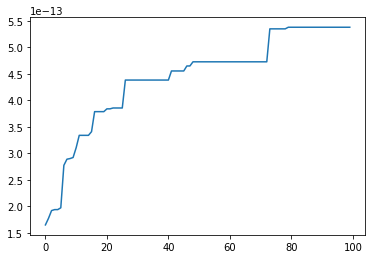

In [130]:
F, fits = ga_main(["inc", ["tensorflow", "theano"]], model, dataset, input_shape, init_input_mut, init_weight_mut, r1, r2, m, 10, db_flag, 100)
plt.plot(fit_grad(fits))

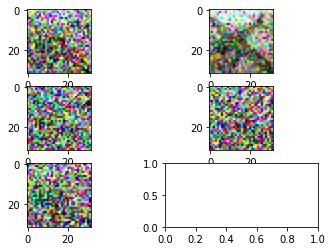

In [18]:
last_images = fits[-1][0]
f, axarr = plt.subplots(3,2)
axarr[0,0].imshow(last_images[0])
axarr[0,1].imshow(last_images[1])
axarr[1,0].imshow(last_images[2])
axarr[1,1].imshow(last_images[3])
axarr[2,0].imshow(last_images[4])


In [1]:
fits

NameError: name 'fits' is not defined

## ToDo
1. Implement Fitness Function as an Abstract Base Class
2. Replace keras by the corresponding backend DL frameworks library
    
    2.1. Convert models of any format to ONNX
    
    2.2. Write scripts specific to the called DL framework libary


3. NaN fitness: Try using layers other than last layer to compute fitness

    3.1. Reshape dimensions of the intermediate layer outputs